In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_picture(name):
    x_path = name
    y_path = './y/sky'+name[7:]
    #print(x_path)
    x = np.load(x_path)
    y = np.load(y_path)
    y_pic = np.zeros_like(x)
    for el in y:
        y_pic[el[0]][el[1]] = 1
    return x, y, y_pic

In [2]:
def get_pic(y):
    y_pic = np.zeros((200, 200))
    for el in y:
        y_pic[el[0]][el[1]] = 1
    return y_pic

In [3]:
x, y, y_pic = get_picture('./x/sky1273.npy')

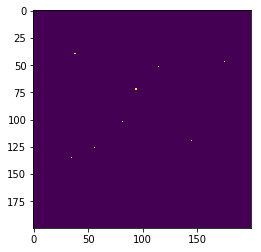

In [4]:
plt.imshow(y_pic)

In [5]:
def get_examples(img, y, h=5,w=5):
    X_good = []
    Y_good = []
    X_bad = []
    Y_bad = []
    H, W = img.shape
    for i in range(h+1, H-2*h):
        for j in range(w + 1, W-2*w):
            piece = img[i-h:i+h+1, j-w:j+w+1]
            ans = y[i][j]
            if ans:
                X_good += [piece]
                Y_good += [ans]
            else:
                X_bad += [piece]
                Y_bad += [ans]
    #print(X_good, X_bad)
    return X_good, Y_good, X_bad, Y_bad

In [6]:
def get_raw_examples(img, h=5,w=5):
    X_good = []
    H, W = img.shape
    for i in range(h+1, H-2*h):
        for j in range(w + 1, W-2*w):
            piece = img[i-h:i+h+1, j-w:j+w+1]
            X_good += [piece]
    return X_good

In [7]:
def get_ans(pred, p=0.8):
    ans = []
    #print(pred.sum())
    _, H, W, _ = pred.shape
    for i in range(0, H):
        for j in range(W):
            if pred[0][i][j][0] > p:
                ans += [[i, j]]
    return ans

In [8]:
from glob import glob
path = './x/sky*.npy'

In [9]:
def get_dataset(path):
    names = glob(path)
    X = []
    y = []
    X1 = []
    y11 = []
    for el in names:
        x, y1, y_pic = get_picture(el)
        cur_x, cur_y, cur_x1, cur_y1 = get_examples(x, y_pic)
        #print(cur_x[0].shape, cur_y[0].shape)
        #print(cur_x1[0].shape, cur_y1[0].shape)
        X += cur_x
        y += cur_y
        X1 += cur_x1
        y11 += cur_y1
    #print(X.shape)
    return X, y, X1, y11


In [10]:
c = 0
def get_slices(x, y):
    x_sl = []
    y_sl = []
    for i in range(20):
        for j in range(20):
            x_sl += [x[i:i+10, j:j+10]]
            y_sl += [x[i:i+10, j:j+10]]
    return x_sl, y_sl

In [11]:
path = './x/sky*.npy'
names = glob(path)
x_data = []
y_data = []
ypic_data = []
for el in names:
    x, y1, y_pic = get_picture(el)
    x_data += [x]
    y_data += [y]
    ypic_data += [y_pic]
print(len(x_data), len(y_data))

947 947


In [12]:
y_data[1]

array([[ 39,  38],
       [ 47, 175],
       [119, 145],
       [126,  56],
       [ 72,  94],
       [ 51, 115],
       [135,  35],
       [102,  82]])

In [13]:
from random import shuffle
def get_batch_generator(x, y, minibatch_size=32, test=0):
    n = np.arange(len(x))
    #shuffle(n)
    cur = 0
    while cur < len(x):
        #print("kek")
        yield np.array(x[cur:cur+minibatch_size])[:,:,:, np.newaxis], \
        np.array(y[cur:cur+minibatch_size]).reshape((min(minibatch_size, len(x) - cur) \
                                                     , 200*200))
        cur += minibatch_size

In [14]:
gen = get_batch_generator(X, y)

NameError: name 'X' is not defined

In [15]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [16]:
def my_mean_squared_error(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-1)

In [17]:
from keras.models import *
from keras.layers import *
import keras

def get_model():
    model = Sequential()
    #model.add(BatchNormalization())
    model.add(Conv2D(10, (3, 3), activation='relu', padding='same'))
    #model.add(Dropout(0.2))
    model.add(Conv2D(20, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(1, (3, 3), activation='relu', padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.4))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

    model.compile(loss=my_mean_squared_error,
                  optimizer=optimizer)
    return model

Using TensorFlow backend.


In [18]:
model = get_model()

In [19]:
data_x = np.array(x_data)
data_y = np.array(ypic_data)

In [ ]:
model.fit(data_x.reshape((*data_x.shape,1)), 
          data_y.reshape((data_y.shape[0], 200*200)),
          validation_split=0.2,
          #class_weight = {0:1, 1:1000},
          batch_size=32, epochs=50)

In [254]:
pred = model.predict(data_x.reshape((*data_x.shape,1))[130:131])
ys = data_y[130:131]
print((((pred-ys.reshape(1, 40000))**2).sum()))

10.079720195085486


In [20]:
n_ep = 1
from tqdm import tqdm_notebook
from time import clock

for epoch in range(n_ep):
    print("D", np.array(x_data).shape, np.array(ypic_data).shape)
    batch_generator = get_batch_generator(x_data, ypic_data, minibatch_size=32)
    #print([s for s in batch_generator])
    print("epoch #{}".format(epoch))
    scores = []
    errors = []
    #print('r')

    t = 0
    for i, batch in tqdm_notebook(enumerate(batch_generator)):
        #print(len(batch))
        cur_X, cur_y = batch
        #print(cur_X.shape, np.array(ypic_data).shape)
        if i % 10 == 0:
            
            score = model.test_on_batch(cur_X, cur_y)
            pred = model.predict(cur_X)
            #print(pred.shape, cur_y.shape, pred.sum(), abs(np.array((pred > 0.5), dtype=int) - cur_y).shape)
            #print(abs(np.array((pred > 0.5), dtype=int) == cur_y).mean())
            #k = abs(np.array((pred > 0.5), dtype=int) == cur_y)
            print(cur_y.shape, pred.shape)
            z = np.sum(np.square(pred - cur_y), axis=-1)
            print(z.mean())
            scores += [((cur_y - pred)**2).sum()/32]
            print("S", score, ((cur_y - pred)**2).sum()/32)
            errors += [score[0]]
            #print(K.round(pred))
            #with sess.as_default():
            #    print(K.mean(K.equal(cur_y, K.cast(K.round(pred),"int64"))).eval())
            #print(keras.metrics.binary_accuracy(np.array(cur_y, dtype=np.float32), pred).eval())
            #print(score[0])
            #scores.append(score[0])
            #detected = detect(model, test_img_dir=test_dir, test=5000)
            #error = compute_metric(detected, gt, img_shapes)
            #errors.append(error)
            #print()
            #print("Score: {}".format(score))
        if i % 1000 == 0:
            print(i, clock() - t)
        #model.train_on_batch(cur_X, cur_y)
    print("mean_score_by_epoch:", np.average(scores))
    print("mean_func:", np.average(errors))

D (947, 200, 200) (947, 200, 200)


NameError: name 'get_batch_generator' is not defined

In [20]:
class model:
    def __init__(self, shared=''):
        '''
        This constructor is supposed to initialize data members.
        Use triple quotes for function documentation. 
        '''
        self.X, self.y, self.X1, self.y11 = [], [], [], []

        self.is_trained=False
        #self.shared=shared

    def fit(self, X, y):
        '''
        This function should train the model parameters.
        Here we do nothing in this example...
        Args:
            X: Training data matrix of dim num_train_samples * num_feat.
            y: Training label matrix of dim num_train_samples * num_labels.
        Both inputs are numpy arrays.
        For classification, labels could be either numbers 0, 1, ... c-1 for c classe
        or one-hot encoded vector of zeros, with a 1 at the kth position for class k.
        The AutoML format support on-hot encoding, which also works for multi-labels problems.
        Use data_converter.convert_to_num() to convert to the category number format.
        For regression, labels are continuous values.
        '''
        from time import clock
        t = clock()
        #for i in range(len(X)):
        #    x = X[i]
            #print(y[i])
            #break
         #   y_pic = get_pic(y[i])
            #print(y_pic.sum())
            #break
          #  cur_x, cur_y, cur_x1, cur_y1 = get_examples(x, y_pic)
          #  self.X += cur_x
          #  self.y += cur_y
          #  self.X1 += cur_x1
          #  self.y11 += cur_y1
        self.X = X
        yy = []
        for el in y:
            yy += [get_pic(el)]
        self.y = yy
        n = len(self.X)
        #ns = np.arange(n)
        from random import shuffle
        #shuffle(ns)
        #self.X = np.array(self.X)[ns]
        #self.y = np.array(self.y)[ns]
        
        self.train_x = []#np.array(self.X)# + list(self.X1[:100*len(X)])
        self.train_y = []#np.array(self.y)# + list(self.y11[:100*len(X)])
        for i in range(len(self.X)):
            x_sl, y_sl = get_slices(self.X[i], self.y[i])
            self.train_x += x_sl
            self.train_y += y_sl
        #print("Dataset", clock()-t)
        #n = len(self.train_x)
        #ns = np.arange(n)
        #from random import shuffle
        #shuffle(ns)

        #print(ns[:10])

        self.train_x = np.array(self.train_x)#[ns]
        self.train_y = np.array(self.train_y)#[ns]
        
        self.model = get_model()
        
        self.model.fit(self.train_x.reshape((*self.train_x.shape,1)), 
                self.train_y.reshape((self.train_y.shape[0],10*10)),
                validation_split=0.25,
                #class_weight = {0:1, 1:100},
                batch_size=32, epochs=50)
        
        self.is_trained=True
        print("Training is done!")

    def predict(self, X):
        '''
        This function should provide predictions of labels on (test) data.
	In out case X is a dictionary of two fields: Fermi Image and its WCS object.
90
        Make sure that the predicted values are in the correct format for the scoring
        metric. For example, binary classification problems often expect predictions
        in the form of a discriminant value (if the area under the ROC curve it the metric)
        rather that predictions of the class labels themselves. For multi-class or multi-labels
        problems, class probabilities are often expected if the metric is cross-entropy.
        Scikit-learn also has a function predict-proba, we do not require it.
        The function predict eventually can return probabilities.
        '''
        y = []
        for i in range(len(X)):
            print(str(i) + '/' + str(len(X)))
            cur = X[i]
            x_sl, _ = get_slices(cur, cur)
            #pieces = get_raw_examples(cur)
            #print(np.array(pieces).shape)
            pred = self.model.predict(x_sl.reshape((*x_sl.shape, 1)))
            #ans = get_ans(pred.reshape((1, 200, 200, 1)))
            #y += [ans]
        return pred#y

    def save(self, path="./"):
        pickle.dump(self, open(path + '_model.pickle', "wb"), 2) 

    def load(self, path="./"):
        print(path)
        modelfile = path + '_model.pickle'
        print(modelfile)
        if os.path.isfile(modelfile):
            with open(modelfile, 'rb') as f:
                self = pickle.load(f)
            print("Model reloaded from: " + modelfile)
        return self

In [21]:
m = model()

In [ ]:
m.fit(x_data, y_data)

Train on 284100 samples, validate on 94700 samples
Epoch 1/50
284100/284100 [==============================] - 61s 215us/step - loss: 36386613.6742 - val_loss: 623022.1981
Epoch 2/50
284100/284100 [==============================] - 60s 211us/step - loss: 15583400.3233 - val_loss: 227984.3907
Epoch 3/50
284100/284100 [==============================] - 60s 210us/step - loss: 11649527.5091 - val_loss: 1302809.5082
Epoch 4/50
284100/284100 [==============================] - 57s 201us/step - loss: 8409567.4620 - val_loss: 283189.8239
Epoch 5/50
284100/284100 [==============================] - 61s 216us/step - loss: 7062328.2159 - val_loss: 126937.3521
Epoch 6/50
284100/284100 [==============================] - 63s 222us/step - loss: 6726759.8886 - val_loss: 240411.9227
Epoch 7/50
284100/284100 [==============================] - 62s 220us/step - loss: 6543661.8767 - val_loss: 54858.6347
Epoch 8/50
284100/284100 [==============================] - 62s 220us/step - loss: 5157627.0677 - val_loss

In [261]:
xx, yy = [x_data[155]], [y_data[155]]


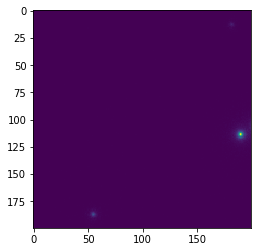

In [262]:
plt.imshow(xx[0])

In [263]:
yy

[array([[ 39,  38],
        [ 47, 175],
        [119, 145],
        [126,  56],
        [ 72,  94],
        [ 51, 115],
        [135,  35],
        [102,  82]])]

In [264]:
y = m.predict(xx)


0/1
0.0


In [280]:
cnt = 0
y = []

for i in range(len(x_data[:10])):
    #print(str(i) + '/' + str(len(x_data)))
    cur = x_data[i]
    pic = ypic_data[i]
    #pieces = get_raw_examples(cur)
    #print(np.array(pieces).shape)
    pred = m.model.predict(cur.reshape((1, *cur.shape, 1)))
    cnt += ((pred.ravel()-pic.ravel())**2).sum()
    #print()
    ans = get_ans(pred.reshape(-1, 200, 200, 1), p=0.001)
    y += [ans]
#print(y)
print(cnt / len(x_data))

0.10561487506872118


In [281]:
y

[[],
 [[199, 160], [199, 161]],
 [[168, 56]],
 [],
 [],
 [],
 [[5, 120]],
 [],
 [],
 [[199, 59], [199, 60]]]

In [283]:
y_data[:10]

[array([[ 39,  38],
        [ 47, 175],
        [119, 145],
        [126,  56],
        [ 72,  94],
        [ 51, 115],
        [135,  35],
        [102,  82]]), array([[ 39,  38],
        [ 47, 175],
        [119, 145],
        [126,  56],
        [ 72,  94],
        [ 51, 115],
        [135,  35],
        [102,  82]]), array([[ 39,  38],
        [ 47, 175],
        [119, 145],
        [126,  56],
        [ 72,  94],
        [ 51, 115],
        [135,  35],
        [102,  82]]), array([[ 39,  38],
        [ 47, 175],
        [119, 145],
        [126,  56],
        [ 72,  94],
        [ 51, 115],
        [135,  35],
        [102,  82]]), array([[ 39,  38],
        [ 47, 175],
        [119, 145],
        [126,  56],
        [ 72,  94],
        [ 51, 115],
        [135,  35],
        [102,  82]]), array([[ 39,  38],
        [ 47, 175],
        [119, 145],
        [126,  56],
        [ 72,  94],
        [ 51, 115],
        [135,  35],
        [102,  82]]), array([[ 39,  38],
        [ 47, 